In [10]:
import numpy as np
import matplotlib.pyplot as plt

import SSN_classes

# Reduced 2D SSN vs Homog Ring SSN
Ahmadian et al. 2013 (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4026108/)

### 1. Homog Ring SSN
[x] the input vector serves as 'Step input' at t=0! instead of impulse input  
[x] The plot from fixed_point is firing rate vs time (dt=1 (ms?))  
[ ] __Why not use Leapfrog Method? more accurate than Euler__  
[ ] Although there is a function called make_noise_cov, it's not used for now.  
[x] __SSNUniform__ requires all elements of __J__ to be non-negative, while __SSNHomogRing__ requires two elements >0, two < 0?  
[ ] __What is the formula to cunstruct a stimulu with two orthogonal gratings?__  
[ ] HomogRing how to set gE/gI? sum of square = 1?  | How to find c and g for two stimulus?
[ ] J_2x2 = np.array([[2.5, -1.3],  [2.4, -1.0]]) * np.pi  # Why there is a pi?  
[ ] When calculating phi, set gE, gI, c = 1? 
[ ] Confirm the calculation of dist (arc)?  
[!] __Why stimulu orientation = 45 in the code, but = 0 in the paper?__  


J_2x2: [[2.5 1.3]
 [2.4 1. ]]

 Warning 1: reached Tmax=500, before convergence to fixed point.
       max(abs(dx./max(abs(xvec), 1.0))) = 0.0234278502101113,   xtol=1e-05.

(501, 4)
Did not reach fixed point.


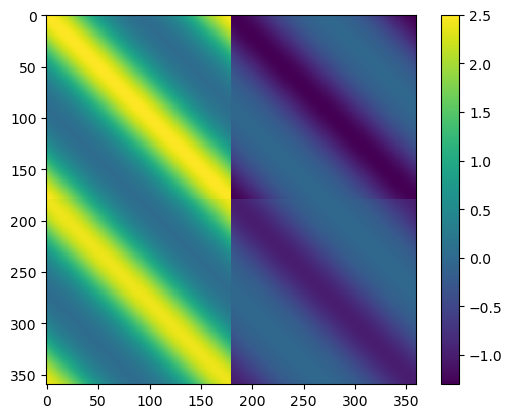

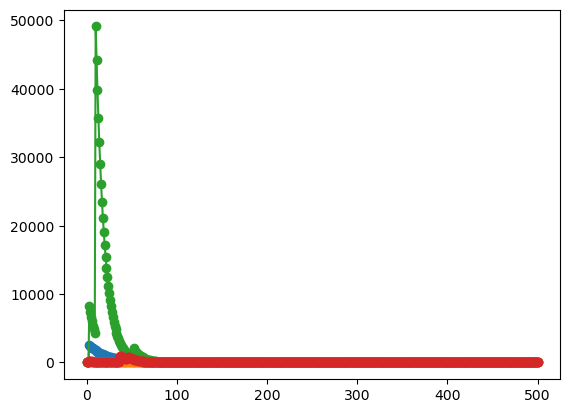

In [11]:
M = 180  # number of neurons in E or I populations (2013 paper had M = 180, but lower (but not too much low) is also fine, and wouldn't really affect anything)
L = 180  # length of the ring (180 degrees)

J_2x2 = np.array([[2.5, 1.3],
                  [2.4, 1.0]])
s_2x2 = np.ones((2,2)) * 32 # in degrees, orientation tuning width of recurrent connections

# make SSN object
ssn = SSN_classes.SSNHomogRing(n=2, k=0.04, tauE=20, tauI=10, 
                               J_2x2=J_2x2, s_2x2=s_2x2, Ne=M, L=L, L1normalize=False)

plt.figure()
print('J_2x2:', J_2x2)
plt.imshow(ssn.W, cmap='viridis', interpolation='nearest')        
plt.colorbar()

# make external input vector corresponding to a grating stimulus
contrast = 20
orientation = 0

ring_input = ssn.make_grating_input(ori_s=orientation,
                                sig_EF=30,  # in degrees, orientation tuning width of external input 
                                gE=1,
                                gI=0,
                                contrast=contrast)

# find fixed point firing rates
rates, convg = ssn.fixed_point_r(ring_input, Tmax = 500, verbose=True, PLOT=True, inds=[0, int(0.5*M), M, M+int(0.5*M)]) #Print angle=0, 90 for E and I

# To check signs of weight matrix
# plt.imshow(ssn.W, cmap='viridis', interpolation='nearest')
# plt.colorbar()


### 2. Equivelant 2D SSN  
Please help me check my calculation for the factor phi (to find equivlant 2D model)

44.31974685969186


<Figure size 640x480 with 0 Axes>

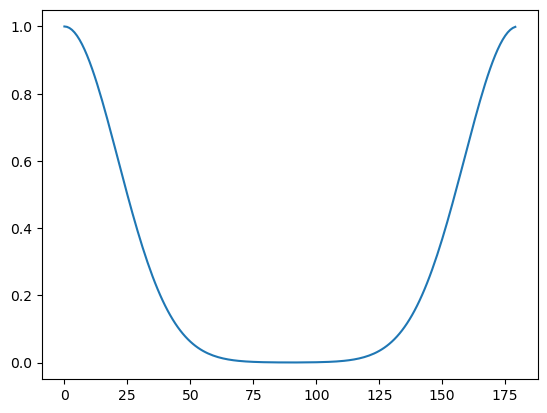

<Figure size 640x480 with 0 Axes>

In [12]:
# Phi = 0.774

# find Phi
ssn = SSN_classes.SSNHomogRing(n=2, k=0.04, tauE=20, tauI=10, 
                               J_2x2=J_2x2, s_2x2=s_2x2, Ne=M, L=L, L1normalize=False)
weight_0 = ssn.W[:,0] # The first column

nomalized_weight_0 = weight_0/weight_0[0] * 1/M
input_g = ssn.make_grating_input(ori_s=orientation,
                                sig_EF=30,  # in degrees, orientation tuning width of external input 
                                gE=1,
                                gI=0,
                                contrast=1)
# print(nomalized_weight_0[0] / (L/M)) # should = 1

distsq = lambda x: np.minimum(np.abs(x), L-np.abs(x))**2
nomalized_weight_0 = np.exp(-distsq(ssn.ori_vec_E)/2/32**2)
# print(nomalized_weight_0)
# from util import Euler2fixedpt, toeplitz
# plt.plot( toeplitz(np.exp(-distsq(ssn.ori_vec_E)/2/32**2) * L / M)[:,0] )

plt.plot(input_g[0:M]**ssn.n)
# Calculate Phi
Phi = np.sum( input_g[0:M]**ssn.n * nomalized_weight_0[0:M] )

print(Phi)


plt.figure()


J_2x2: [[2.5 1.3]
 [2.4 1. ]]

 Warning 1: reached Tmax=500, before convergence to fixed point.
       max(abs(dx./max(abs(xvec), 1.0))) = 6.555340376815655e-05,   xtol=1e-05.

(501, 2)
Did not reach fixed point.
[0.16565195 0.16900479]


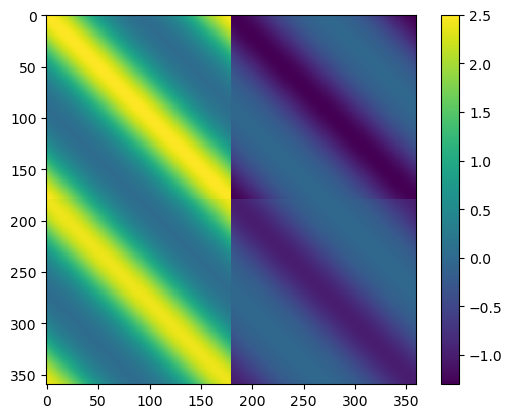

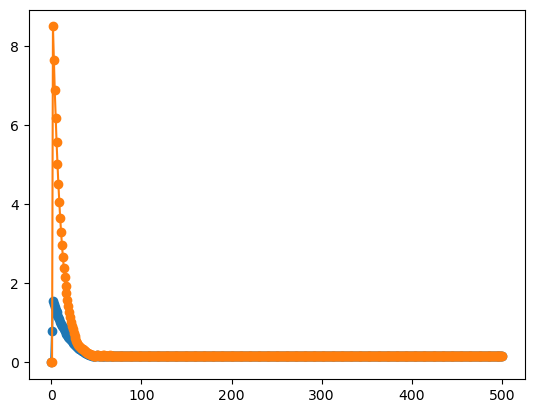

In [13]:
ssn_2d = SSN_classes.SSN_2D(n=2, k=0.04, tauE=20, tauI=10, Jee = [0][0]*Phi, Jei = J_2x2[1][0]*Phi, Jie=J_2x2[0][1]*Phi, Jii=J_2x2[1][1]*Phi)

plt.figure()
print('J_2x2:', J_2x2)
plt.imshow(ssn.W, cmap='viridis', interpolation='nearest')        
plt.colorbar()

input = np.array([1,0]) * contrast



# find fixed point firing rates
rates, convg = ssn_2d.fixed_point_r(input, Tmax = 500, verbose=True, PLOT=True, inds=[0,1])
print(rates)
# plt.plot(rates)
# plt.yscale('log')  # Set x-axis to logarithmic scale

# To check signs of weight matrix
# plt.imshow(ssn_2d.W, cmap='viridis', interpolation='nearest')
# plt.colorbar()


# Retinotopic-map SSN of Holt, Miller, and Ahmadian, 2023
https://www.biorxiv.org/content/10.1101/2023.05.11.540442v1.abstract

This is (almost) the SSN in Fig. 4 of the above paper.
(Note, however, here I construct the single-synaptic-receptor-type SSN; to get the version of the model in the paper you have to use `SSN_classes.SSN2DTopoV1_AMPAGABA` and specify other parameters, including `ssn.tau_s`.)

In [14]:
from dataclasses import dataclass

@dataclass
class GridPars:
    gridsize_Nx: int # number of grid-points across each edge of the 2D retinotopic grid
    gridsize_deg: float # edge length in degrees of visual angle
    magnif_factor: float # cortical magnification factor in mm/deg
    hyper_col: float # hypercolumn size (i.e. period of orientation map) in mm 

(481, 1)


0.0

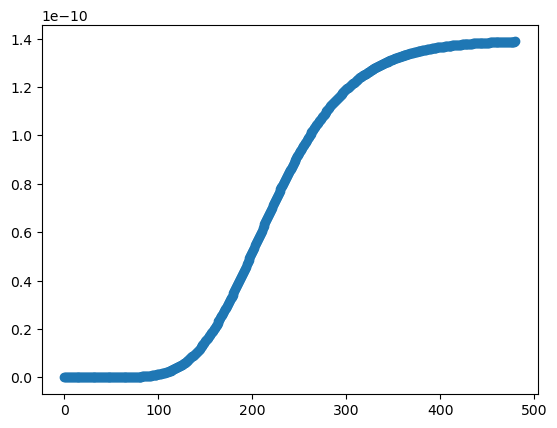

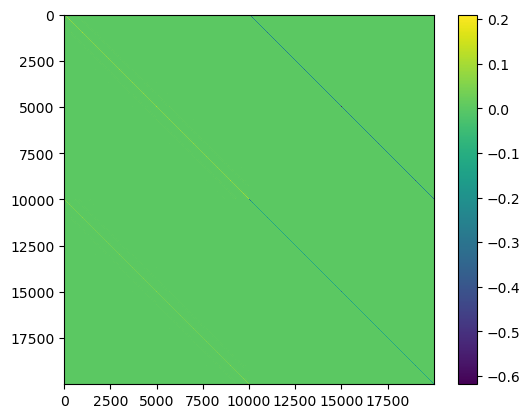

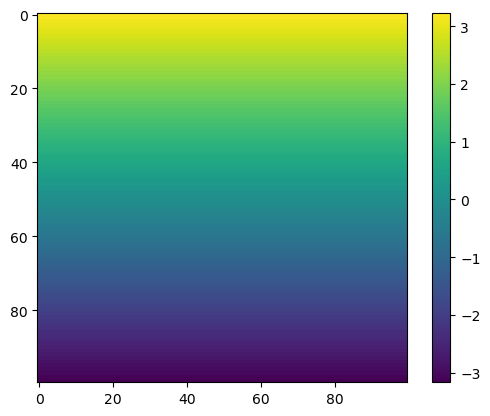

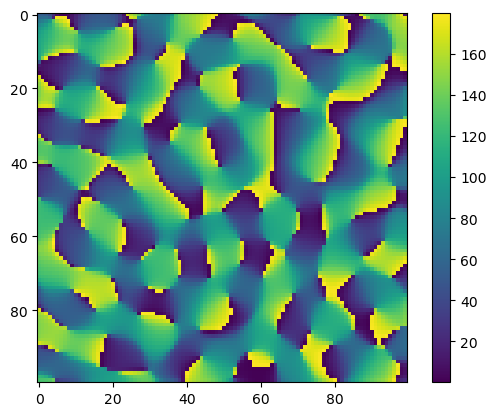

In [15]:
grid_pars = GridPars(**{'gridsize_Nx': 100,      # Num of columns in x-direction
                        'gridsize_deg': 3.2,    # Grid size in x-direction (unit: degree)
                        'hyper_col': 1,   # if you actually want to get an orientation map, a reasonable choice would be 0.8 to 1.0 mm
                        'magnif_factor': 2})

psi = 0.774
conn_pars = dict(J_2x2= np.array([[1.495, -1.034],
                                  [1.110, -0.517]]) * np.pi * psi,
                 s_2x2= np.array([[0.2654, 0.09],
                                  [0.2940, 0.09]]), # in mm
                 p_local= [0., 0.],
                 sigma_oris= 45,
                 PERIODIC= False,
                 CellWiseNormalized=True)

# make SSN object
ssn = SSN_classes.SSN2DTopoV1(n=2,
                              k=0.04,
                              tauE=20,
                              tauI=10, 
                              grid_pars=grid_pars,
                              conn_pars=conn_pars)

# make feedforward input vector for a grating stimulus
contrasts = 50
radius = 0.75
orientation = 0




input_pars = {'gE' : 0.476,
              'gI' : 0.232,
             'sig_ori_EF': 32,
             'sig_ori_IF': 32,
             'sigma_RF': 0.04}
             

input = contrast * ssn.make_grating_input(radius, ori_s=orientation,
                                          **input_pars)

# find fixed point firing rates
rates, convg = ssn.fixed_point_r(input, verbose=False, PLOT=True)

# plt.imshow(ssn.W, cmap='viridis', interpolation='nearest')
# plt.colorbar()

plt.figure()
plt.imshow(ssn.W, cmap='viridis', interpolation='nearest')     
plt.colorbar()

plt.figure()
plt.imshow(ssn.y_map, cmap='viridis', interpolation='nearest')     
plt.colorbar()

plt.figure()
plt.imshow(ssn.ori_map, cmap='viridis', interpolation='nearest')     
plt.colorbar()


ssn.W[200,280]



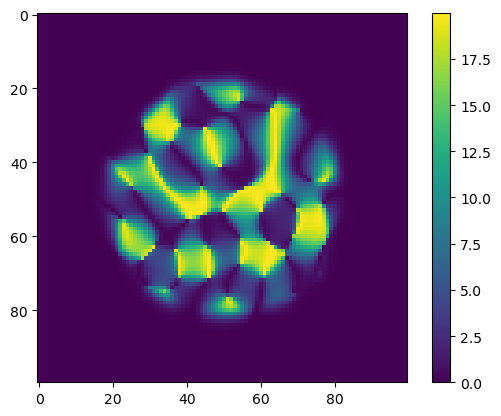

In [53]:
input_pars = {'gE' :1,
              'gI' : 0.232,
              'sig_ori_EF': 32,
              'sig_ori_IF': 32,
              'sigma_RF': 3e-2,
              'radius_s': 1,
              'ori_s': 0}

input = contrast * ssn.make_grating_input(**input_pars)
plt.figure()
plt.imshow(ssn.vec2map(input)[0], cmap='viridis', interpolation='nearest')     
plt.colorbar()

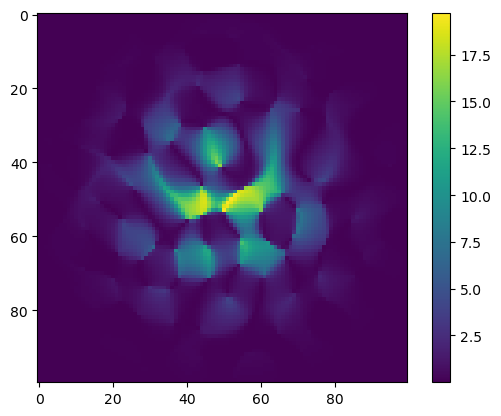

In [57]:
input_pars = {'gE' :1,
              'gI' : 0.232,
             'sig_ori_EF': 32,
             'sig_ori_IF': 32,
             'sigma_Gabor': 0.5,
              'ori_s': 0}
             

input = contrast * ssn.make_gabor_input(**input_pars)
plt.figure()
plt.imshow(ssn.vec2map(input)[0], cmap='viridis', interpolation='nearest')     
plt.colorbar()

For Fig. 6 of the above paper, replace the following according to:

In [16]:
conn_pars = dict(J_2x2= np.array([[1.495, -1.034],
                                  [1.110, -0.517]]) * np.pi * psi,
                 s_2x2= np.array([[0.2654, 0.09],
                                  [0.2940, 0.09]]), # in mm
                 p_local= [0., 0.],
                 sigma_oris= 45,
                 PERIODIC= False,
                 CellWiseNormalized=True)

input_pars = {'gE' : 0.476,
              'gI' : 0.232,
             'sig_ori_EF': 32,
             'sig_ori_IF': 32,
             'sigma_RF': 0.04}